<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/Exploring_Dicom_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Dicom Images

## Import Packages

In [1]:
#https://www.programcreek.com/python/example/97517/dicom.read_file
# https://www.programcreek.com/python/?code=xf4j%2Faapm_thoracic_challenge%2Faapm_thoracic_challenge-master%2Fconvert_data.py

!pip install pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import glob
import tqdm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import measure, morphology

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#connect the google drive to the google colab
from google.colab import drive
drive.mount('/content/drive')
#Directories
image_train='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/'
patients=os.listdir(image_train)
patients.sort()
image_test='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test/'
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
train=pd.read_csv(train_csv)
test=pd.read_csv(test_csv)

sub=pd.read_csv(sub_csv)
sub[['Patient','Weeks']]=sub.Patient_Week.str.split("_",expand = True)
#creating path column for dcm files of patient
train['Path']=image_train + train['Patient']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


Text(0.5, 1.0, '# of DICOM per patient of Training Data')

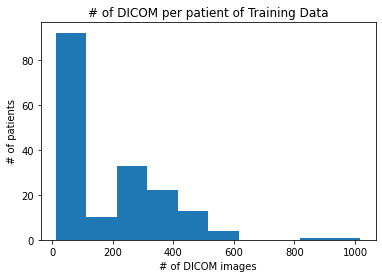

In [4]:
# Number of dcm images for each patient
dcm_each_patient = [] 
for d in os.listdir(image_train):
    dcm_each_patient.append(len(os.listdir(image_train + d)))
  # lets visualize trainig data
plt.hist(dcm_each_patient)
plt.ylabel('# of patients')
plt.xlabel('# of DICOM images')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.title('# of DICOM per patient of Training Data')

In [5]:
#Let's read dicom file
d='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/ID00007637202177411956430/1.dcm'
dicom.dcmread(d)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12297650151329871895440507938349160734
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

Let's make two helper functions.
(https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)
> ***load_dcm*** will load all DICOM images from a folder into a list for manipulation.

> The voxel values in the images are raw. ***get_pixels_hu*** converts raw values into Houndsfeld units

*   The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
*   Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).




In [3]:
#https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

# Load the dcm in given folder path
def load_dcm(path):
    scans = os.listdir(path)
    slices = []  
    for scan in scans:
        with dicom.dcmread(path + '/' + scan) as s:
            slices.append(s)
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    for s in slices:
        s.SliceThickness = slice_thickness      
    return slices

In [4]:
def get_pixels_hu(dcms):
    image = np.stack([s.pixel_array for s in dcms])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)     
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

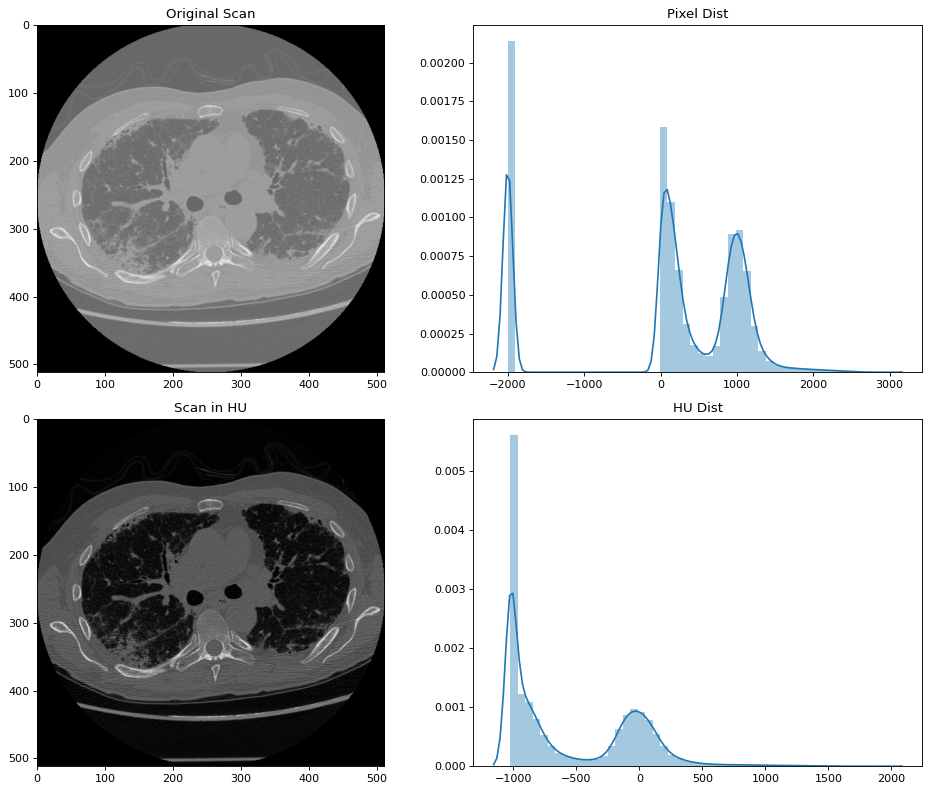

In [8]:
patient_scans = load_dcm(image_train + patients[0])
patient_hu = get_pixels_hu(patient_scans)
plt.figure(figsize=(12,10), dpi= 80)
plt.subplot(2, 2, 1)
plt.imshow(patient_scans[13].pixel_array, cmap=plt.cm.gray)
plt.title('Original Scan')
plt.subplot(2, 2, 2)
sns.distplot(patient_scans[13].pixel_array.flatten()).set_title('Pixel Dist')
plt.subplot(2, 2, 3)
plt.imshow(patient_hu[13], cmap=plt.cm.gray)
plt.title('Scan in HU')

plt.subplot(2, 2, 4)
sns.distplot(patient_hu[13].flatten()).set_title('HU Dist')
plt.tight_layout()


Checking with the HU table shows:

*   There is a lot of air, the peak around -1000
*   At around -500 there are some pixels classified as Lung;
*   The smaller gaussian-shaped peak at 0 indicates soft tissues;
*   The distribution tail from 700 onward shows the presence of bones.





### Resampling

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

(https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)

In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
  spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
  spacing = np.array(list(spacing))
    # Determine current pixel spacing
  resize_factor = spacing / new_spacing
  new_real_shape = image.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize_factor = new_shape / image.shape
  new_spacing = spacing / real_resize_factor
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
  return image, new_spacing

In [10]:
#Applying the resample function on the first patinet
pix_resampled, spacing = resample(patient_hu, patient_scans, [1,1,1])
print("Shape before resampling\t", patient_hu.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (30, 512, 512)
Shape after resampling	 (300, 334, 334)


Displaying an image of patient ID00009637202177434476278 which has 394 dicom files. 

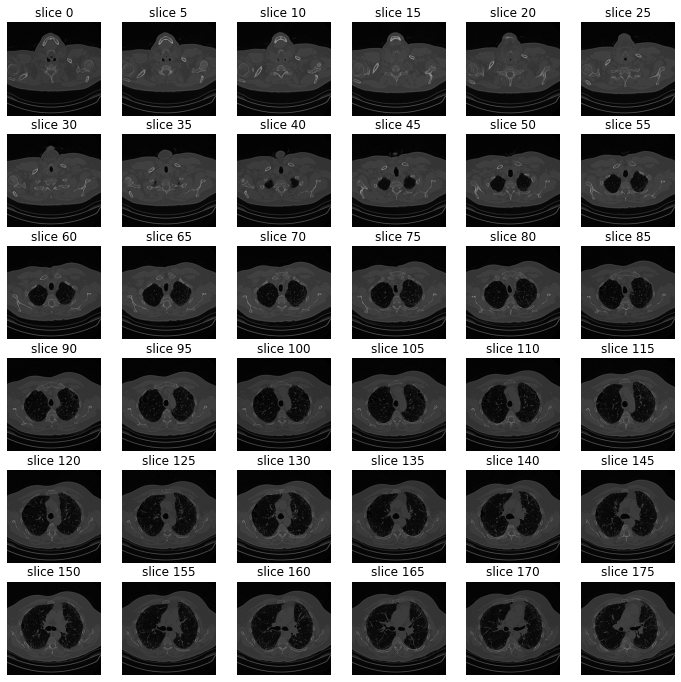

In [11]:
#displaying image of patient ID00009637202177434476278 every five slices and see the difference.
patient_scans = load_dcm(image_train + patients[1])
patient_hu = get_pixels_hu(patient_scans)
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=5):
  fig,ax = plt.subplots(rows,cols,figsize=[12,12])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(patient_hu)

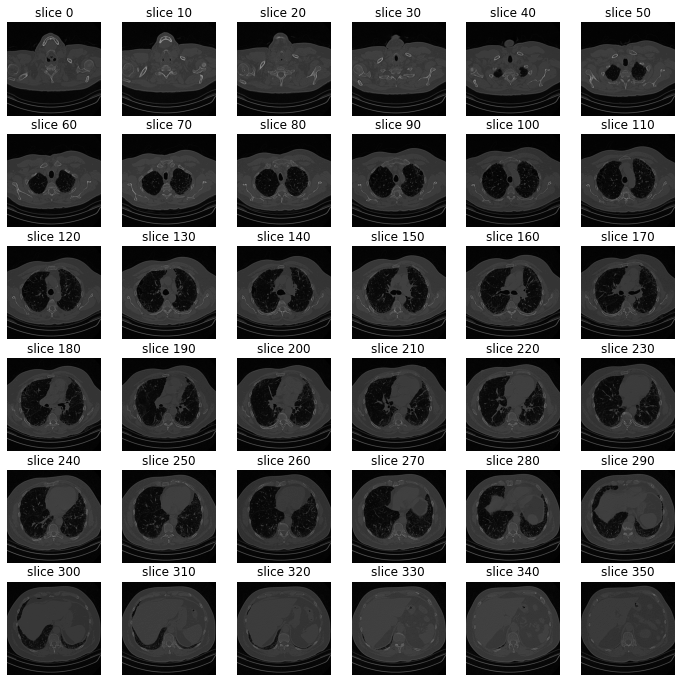

In [13]:
#displaying image of patient ID00009637202177434476278 every ten slices.
patient_scans = load_dcm(image_train + patients[1])
patient_hu = get_pixels_hu(patient_scans)
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=10):
  fig,ax = plt.subplots(rows,cols,figsize=[12,12])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(patient_hu)

In [ ]:
incomplete_scan=['ID00132637202222178761324','ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184']

In [6]:
#there are incomplete scans with no 
incomplete_scan=['ID00132637202222178761324','ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184']
pix_resample=[]
for patient in patients[:10]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled0 = pd.DataFrame.from_dict(pix_resample)
#let's pickle for later use
resampled0.to_pickle("resampled0.pkl")

In [ ]:
pix_resample1=[]
for patient in patients[10:20]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample1.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled1 = pd.DataFrame.from_dict(pix_resample1)
#let's pickle for later use
resampled1.to_pickle("resampled1.pkl")

In [ ]:
pix_resample2=[]
for patient in patients[20:30]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample2.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled2 = pd.DataFrame.from_dict(pix_resample2)
#let's pickle for later use
resampled2.to_pickle("resampled2.pkl")

In [ ]:
pix_resample3=[]
for patient in patients[30:40]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample3.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled3 = pd.DataFrame.from_dict(pix_resample3)
#let's pickle for later use
resampled3.to_pickle("resampled3.pkl")

In [ ]:
pix_resample4=[]
for patient in patients[40:50]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample4.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled4 = pd.DataFrame.from_dict(pix_resample4)
#let's pickle for later use
resampled4.to_pickle("resampled4.pkl")

In [ ]:
pix_resample5=[]
for patient in patients[50:60]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample5.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled5 = pd.DataFrame.from_dict(pix_resample5)
#let's pickle for later use
resampled5.to_pickle("resampled5.pkl")

In [ ]:
pix_resample6=[]
for patient in patients[60:70]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample6.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled6 = pd.DataFrame.from_dict(pix_resample6)
#let's pickle for later use
resampled6.to_pickle("resampled6.pkl")

In [ ]:
pix_resample7=[]
for patient in patients[70:80]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample7.append(pix_resampled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
# Convert to a pd.DataFrame from dict
resampled7 = pd.DataFrame.from_dict(pix_resample7)
#let's pickle for later use
resampled7.to_pickle("resampled7.pkl")

In [ ]:
pix_resample8=[]
for patient in patients[80:90]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample8.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled8 = pd.DataFrame.from_dict(pix_resample8)
#let's pickle for later use
resampled8.to_pickle("resampled8.pkl")

In [ ]:
pix_resample9=[]
for patient in patients[90:100]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample9.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled9 = pd.DataFrame.from_dict(pix_resample9)
#let's pickle for later use
resampled9.to_pickle("resampled9.pkl")

In [ ]:
pix_resample10=[]
for patient in patients[100:110]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample10.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled10 = pd.DataFrame.from_dict(pix_resample10)
#let's pickle for later use
resampled10.to_pickle("resampled10.pkl")

In [ ]:
pix_resample11=[]
for patient in patients[110:120]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample11.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled11 = pd.DataFrame.from_dict(pix_resample11)
#let's pickle for later use
resampled11.to_pickle("resampled11.pkl")

In [ ]:
pix_resample12=[]
for patient in patients[120:130]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample12.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled12 = pd.DataFrame.from_dict(pix_resample12)
#let's pickle for later use
resampled12.to_pickle("resampled12.pkl")

In [ ]:
pix_resample13=[]
for patient in patients[130:140]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample13.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled13 = pd.DataFrame.from_dict(pix_resample13)
#let's pickle for later use
resampled13.to_pickle("resampled13.pkl")

In [ ]:
pix_resample14=[]
for patient in patients[140:150]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample14.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled14 = pd.DataFrame.from_dict(pix_resample14)
#let's pickle for later use
resampled14.to_pickle("resampled14.pkl")

In [ ]:
pix_resample15=[]
for patient in patients[150:160]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample15.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled15 = pd.DataFrame.from_dict(pix_resample15)
#let's pickle for later use
resampled15.to_pickle("resampled15.pkl")

In [ ]:
 pix_resample16=[]
for patient in patients[160:]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    pix_resample16.append(pix_resampled)

In [ ]:
# Convert to a pd.DataFrame from dict
resampled16 = pd.DataFrame.from_dict(pix_resample16)
#let's pickle for later use
resampled16.to_pickle("resampled16.pkl")

In [ ]:
#Combine all resamples to one dataframe
frames=[resampled0,resampled1,resampled2,resampled3,resampled4,resampled5,resampled6,resampled7,resampled8,resampled9,resampled10,resampled11,resampled12,resampled13,resampled14,resampled15,resampled16]
resample = pd.concat(frames)
resample.head()

,0
0,"[[[-1024, -1024, -1024, -1024, -1024, -1024, -..."
1,"[[[-1024, -1024, -1022, -1024, -995, -1030, -6..."
2,"[[[-1003, -998, -946, -967, -954, -1033, -969,..."
3,"[[[-2048, -2048, -2048, -2048, -2048, -2048, -..."
4,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [7]:
def plot_3d(image, threshold=-300, step_size=1,):
  p = image.transpose(2,1,0)
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[facesnm, ` to generate a collection of triangles
  mesh = Poly3DCollection(verts[faces], alpha=0.70)
  face_color = [0.45, 0.45, 0.75]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)

  ax.set_xlim(0, p.shape[0])
  ax.set_ylim(0, p.shape[1])
  ax.set_zlim(0, p.shape[2])

  plt.show()

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

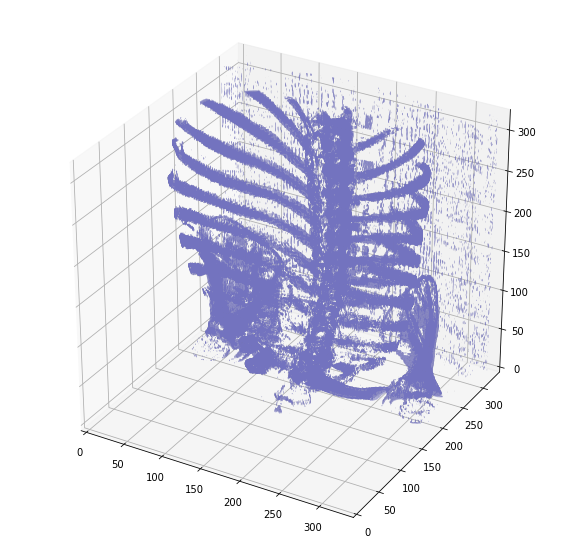

In [16]:
plot_3d(pix_resample[2], 600)


In [8]:
def largest_label_volume(im, bg=-1):
  vals, counts = np.unique(im, return_counts=True)
  counts = counts[vals != bg]
  vals = vals[vals != bg]
  biggest = vals[np.argmax(counts)]
  return biggest

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
  binary_image = np.array(image > -320, dtype=np.int8)+1
  labels = measure.label(binary_image)
  background_label = labels[0,0,0]
    
    #Fill the air around the person
  binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like morphological closing)
  if fill_lung_structures:
      # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)
            
      if l_max is not None: #This slice contains some lung
        binary_image[i][labeling != l_max] = 1

  binary_image -= 1 #Make the image actual binary
  binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None: # There are air pockets
    binary_image[labels != l_max] = 0
 
  return binary_image

In [9]:
masked_lung=[]
for patient in patients[:50]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung=segment_lung_mask(pix_resample, False)
    segmented_lung_fill=segment_lung_mask(pix_resample, True)
    masked_lung.append(segmented_lung_fill-segmented_lung)

In [19]:
masked_lung1=[]
for patient in patients[50:100]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung=segment_lung_mask(pix_resample, False)
    segmented_lung_fill=segment_lung_mask(pix_resample, True)
    masked_lung1.append(segmented_lung_fill-segmented_lung)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


IndexError: ignored

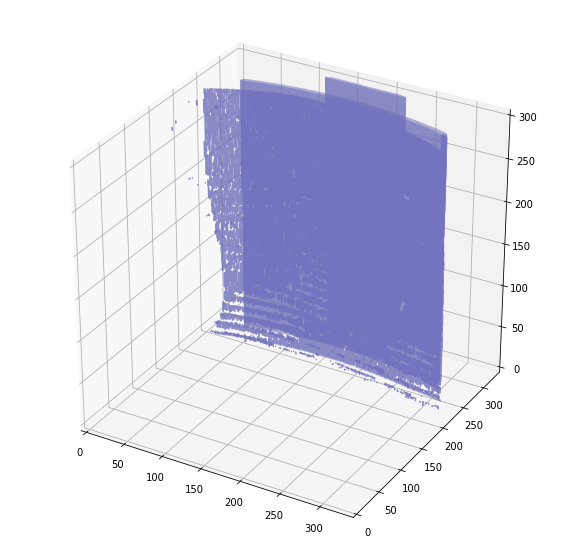

In [11]:
plot_3d(masked_lung[0],0)

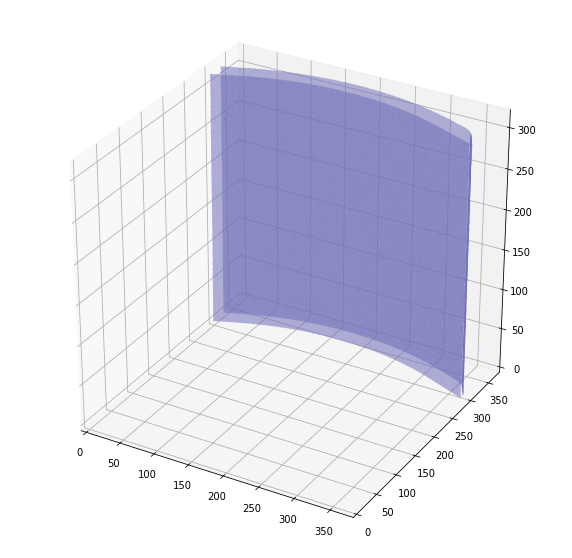

In [10]:
plot_3d(masked_lung[1],0)

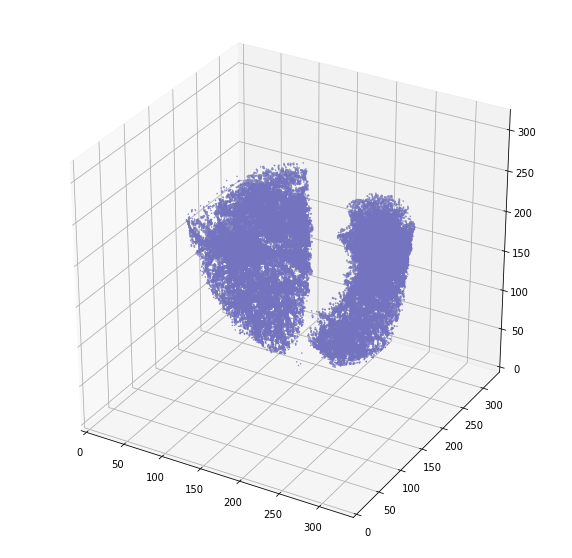

In [ ]:
plot_3d(masked_lung[2],0)

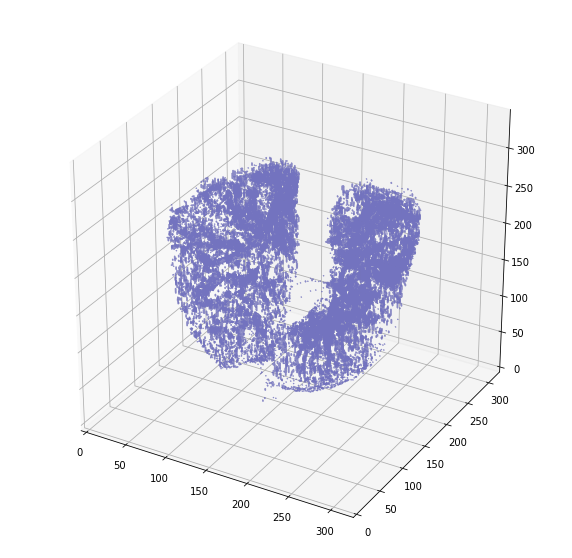

In [ ]:
plot_3d(masked_lung[3],0)

In [ ]:
segmented_lung_fill=[]
for patient in patients[100:150]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung.append(segment_lung_mask(pix_resampled, False))

In [ ]:
segmented_lung_fill=[]
for patient in patients[150:]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resampled, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung.append(segment_lung_mask(pix_resampled, False))

## Normalization
Our values currently range from -1024 to around 2000. Since our target is the lung, anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. We can use the following code

In [12]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
  image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
  image[image>1] = 1.
  image[image<0] = 0.
  return image

## Zero centering
The final preprocessing step, it is advisory to zero center the data so that the mean value is 0. To do this simply subtract the mean pixel value from all pixels.




In [13]:
PIXEL_MEAN = 0.25 #value taken from gzuidhof's kernel

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [14]:
## applying all the rquirements to the dicom files and make it ready for analysis
preprocessed_dicom=[]
for patient in patients[:10]:
  if patient not in incomplete_scan:
    patients_scans=load_dcm(image_train+patient)
    patients_hu=get_pixels_hu(patients_scans)
    pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
    segmented_lung=segment_lung_mask(pix_resample, False)
    segmented_lung_fill=segment_lung_mask(pix_resample, True)
    masked_lung=segmented_lung_fill-segmented_lung
    normalized_image=normalize(masked_lung)
    preprocessed_dicom.append(zero_center(normalized_image))

In [15]:
#let's plot randomly selected image
plot_3d(preprocessed_dicom[5])

ValueError: ignored

# Mapping DICOM and csv training files

In [ ]:
def final_dicom(patient, image):
  preprocessed_dicom={}
  for patient in patients[:10]:
    if patient not in incomplete_scan:
      patients_scans=load_dcm(image_train+patient)
      patients_hu=get_pixels_hu(patients_scans)
      pix_resample, spacing = resample(patients_hu, patients_scans, [1,1,1])
      segmented_lung=segment_lung_mask(pix_resample, False)
      segmented_lung_fill=segment_lung_mask(pix_resample, True)
      masked_lung=segmented_lung_fill-segmented_lung
      normalized_image=normalize(masked_lung)
      preprocessed_dicom=zero_center(normalized_image)
      dicom_image=dict(zip([patient],preprocessed_dicom))
      return dicom_image


In [ ]:
#select patients that have a complete scan images
train_data=train[~train.Patient.isin(incomplete_scan)]
train_data.shape